In [5]:
# https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
import tensorflow as tf
import matplotlib.pyplot as plt 
import pathlib
import PIL
import numpy as np 

# specifying file paths to training and testing dataset
data_dir_train = pathlib.Path(r"W:\tensorflow\intel_image_classification/seg_train/seg_train")
data_dir_test = pathlib.Path(r"W:\tensorflow\intel_image_classification/seg_test/seg_test")

In [6]:
# defining image height and width in pixels
image_height = image_width = 150
# loading training dataset from data_dir_train
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory= data_dir_train,
    batch_size= 32,
    image_size= (image_height, image_width),
    seed= 123
)

Found 14034 files belonging to 6 classes.


In [7]:
# loading testing dataset from data_dir_train
val_ds = tf.keras.utils.image_dataset_from_directory(
    directory= data_dir_test,
    batch_size= 32,
    image_size= (image_height, image_width),
    seed= 123
)

Found 3000 files belonging to 6 classes.


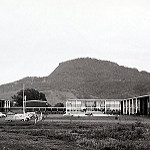

In [8]:
# displaying the first image in training dataset
image = list(data_dir_train.glob("*/*"))
PIL.Image.open(image[0])

In [9]:
# class names
class_names = train_ds.class_names
class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

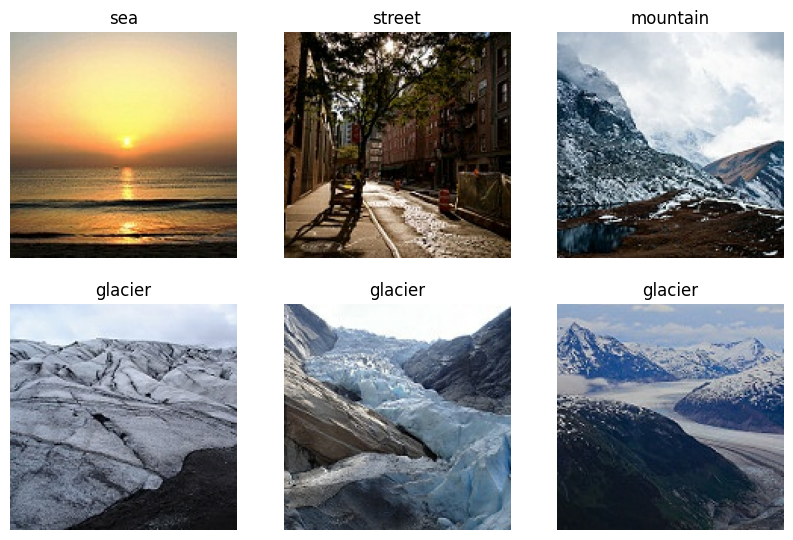

In [10]:
# plotting images from the training dataset
plt.figure(figsize= (10,10))
# .take method takes one batch of data from the training dataset, returning images and their respective labels.
for images, labels in train_ds.take(1):
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        # converting image from tensor to numpy and then 8 bit unsigned integer so that it can be shown using matplotlib 
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [11]:
# .cache caches the dataset either on in memory or on local storage. This will save some operations (like file opening and data reading) from being executed during each epoch
# .prefetch overlaps data preprocessing and model execution while training.

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

filters- Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).

kernel size- An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.

we first rescale the input images to be between 0 and 1
2d convolutional layer with padding type as "same" and activation function "relu" is used with increasing number of filters each time its used
2d maxpooling layer is used to extract important features from the convolutional layer
the output from the last maxpooling layer is then flattened and passed to a densely connected neural network layer with activation function "relu"
the last layer is a densely connected neural network layer with units equal to the length of class names. this last layer is what gives us the prediction made by our model

In [12]:
# defining the model

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale= 1./255, input_shape= (image_height, image_width, 3)),
    tf.keras.layers.Conv2D(16, 3, padding= "same", activation= "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding= "same", activation= "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding= "same", activation= "relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation= "relu"),
    tf.keras.layers.Dense(len(class_names))
])

In [13]:
# compiling the model with sparse categorical crossentropy as loss and accuracy as the metric. from_logits= True argument is used to define that inputs are logit tensors

model.compile(optimizer= "adam", loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= True), metrics= ["accuracy"])

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        1

In [15]:
# setting up model checkpoints and only saving weights

checkpoint_path = r"W:\tensorflow\checkpoints\intel_image_classification_checkpoint.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath= checkpoint_path, save_weights_only= True , verbose= 1)

In [16]:
# setting up early stopping callback, this will start working after 5 epochs and stop the training if there are no improvements in 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= "val_loss", patience= 3, start_from_epoch= 5, verbose= 1)

In [17]:
# tensorboard callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= "./logs", histogram_freq= 1)

In [19]:
# fitting the model to the data

epochs = 15
model_train = model.fit(train_ds, epochs= epochs, validation_data = val_ds, callbacks= [cp_callback, early_stopping, tensorboard_callback])

Epoch 1/15
439/439 [==============================] - ETA: 0s - loss: 0.6451 - accuracy: 0.7666
Epoch 1: saving model to W:\tensorflow\checkpoints\intel_image_classification_checkpoint.ckpt
439/439 [==============================] - 138s 314ms/step - loss: 0.6451 - accuracy: 0.7666 - val_loss: 0.7067 - val_accuracy: 0.7380
Epoch 2/15
439/439 [==============================] - ETA: 0s - loss: 0.4785 - accuracy: 0.8316
Epoch 2: saving model to W:\tensorflow\checkpoints\intel_image_classification_checkpoint.ckpt
439/439 [==============================] - 96s 218ms/step - loss: 0.4785 - accuracy: 0.8316 - val_loss: 0.6470 - val_accuracy: 0.7733
Epoch 3/15
439/439 [==============================] - ETA: 0s - loss: 0.3646 - accuracy: 0.8715
Epoch 3: saving model to W:\tensorflow\checkpoints\intel_image_classification_checkpoint.ckpt
439/439 [==============================] - 153s 350ms/step - loss: 0.3646 - accuracy: 0.8715 - val_loss: 0.6882 - val_accuracy: 0.7830
Epoch 4/15
439/439 [======

In [20]:
# .history method returns a list with given parameter in each epoch accuracy is printed below as an example
acc = model_train.history["accuracy"]
val_acc = model_train.history["val_accuracy"]

loss = model_train.history["loss"]
val_loss = model_train.history["val_loss"]

acc

[0.7666381597518921,
 0.8316231966018677,
 0.8714550137519836,
 0.9055864214897156,
 0.9260367751121521,
 0.9427105784416199,
 0.9537551403045654,
 0.9672937393188477,
 0.9742767810821533]

Text(0.5, 1.0, 'training loss and validation loss')

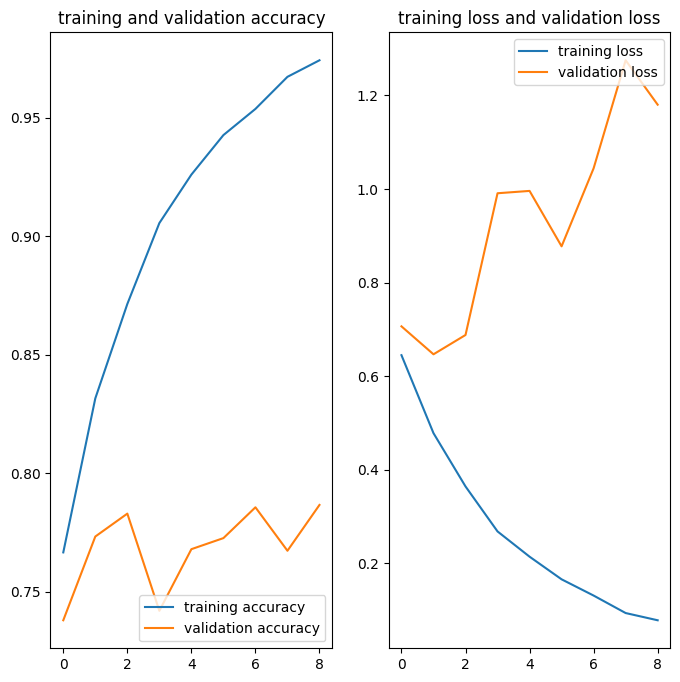

In [25]:
epochs_range = range(early_stopping.stopped_epoch + 1)

# plotting the graph between accuracy and validation accuracy on each epoch
plt.figure(figsize= (8,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label= "training accuracy")
plt.plot(epochs_range, val_acc, label= "validation accuracy")
plt.legend(loc= "lower right")
plt.title("training and validation accuracy")
# plotting the graph between loss and validation loss on each epoch
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label= "training loss")
plt.plot(epochs_range, val_loss, label= "validation loss")
plt.legend(loc= "upper right")
plt.title("training loss and validation loss")

In [37]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4400), started 0:01:57 ago. (Use '!kill 4400' to kill it.)

In [27]:
# loading model from checkpoint. only run this cell after first model training is complete

model.load_weights(checkpoint_path)
model.evaluate(val_ds)

 1/94 [..............................] - ETA: 5s - loss: 0.6605 - accuracy: 0.8750

94/94 [==============================] - 3s 34ms/step - loss: 1.1804 - accuracy: 0.7867


[1.1803725957870483, 0.7866666913032532]

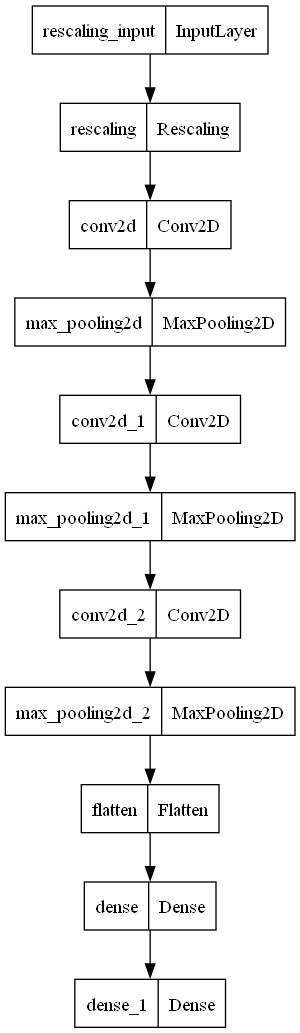

In [28]:
# visualizing the model

tf.keras.utils.plot_model(model)

In [29]:
# converting the model into tflite format for usage in application

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(r"W:\tensorflow\models/intel_image_classification.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\wreak\AppData\Local\Temp\tmpb2z75nch\assets


INFO:tensorflow:Assets written to: C:\Users\wreak\AppData\Local\Temp\tmpb2z75nch\assets


In [30]:
TF_MODEL_FILE_PATH = r"W:\tensorflow\models/intel_image_classification.tflite"
# interpreter interface for running tf lite models.
interpreter = tf.lite.Interpreter(TF_MODEL_FILE_PATH)

In [31]:
# getting the names of inputs and outputs of the model
interpreter.get_signature_list()

{'serving_default': {'inputs': ['rescaling_input'], 'outputs': ['dense_1']}}

In [32]:
# defining the classifier from the tflite model that we imported. get_signature_runner gets callable for inference
classify_lite = interpreter.get_signature_runner()

In [34]:
# loading image and rescaling it
pred_image = tf.keras.utils.load_img(r"W:\tensorflow\intel_image_classification\seg_pred\seg_pred\test.jpg", target_size= (150, 150))

# creating a batch
image_array = tf.expand_dims(pred_image, 0)

predictions = model.predict(image_array)
# normalizing the logit returned by predictions
score = tf.nn.softmax(predictions)

# argmax returns the index and np.max returns highest probability
print(f"the image belongs to {class_names[np.argmax(score)]} with the confidence of {np.max(score)}")

1/1 [==============================] - 0s 117ms/step
the image belongs to mountain with the confidence of 0.9853531718254089


In [35]:
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset reference later for batch inference